In [49]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate, cross_val_score

In [48]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, precision_recall_fscore_support
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from random import seed
from datetime import datetime

In [62]:
expected_model_version = '1.0'
model_path = '../models/ski_resort_pricing_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

Expected model not found


# Loading data

In [3]:
games = pd.read_csv("/Users/cyn/Desktop/nfl-big-data-bowl-2024/games.csv")
players = pd.read_csv("/Users/cyn/Desktop/nfl-big-data-bowl-2024/players.csv")
plays = pd.read_csv("/Users/cyn/Desktop/nfl-big-data-bowl-2024/plays.csv")
tackles = pd.read_csv("/Users/cyn/Desktop/nfl-big-data-bowl-2024/tackles.csv")
week2 = pd.read_csv("/Users/cyn/Desktop/nfl-big-data-bowl-2024/tracking_week_2.csv")

In [4]:
# Merging Data to get dataset

dataset = week2.merge(players, on = ['nflId', 'displayName'], how = 'outer').merge(games, on = 'gameId' , how = 'outer').merge(tackles, on = ['gameId', 'nflId', 'playId'] , how = 'outer').merge(plays, left_on = ['gameId', 'playId', 'nflId'], right_on = ['gameId', 'playId', 'ballCarrierId'] , how = 'inner')

In [5]:
dataset['Foul'] = np.empty(len(dataset))
for i in range(len(dataset)):
    if pd.isna(dataset.foulNFLId1[i]) and pd.isna(dataset.foulNFLId2[i]):
        dataset.Foul[i] = 0
    else:
        dataset.Foul[i] = 1

/var/folders/1v/cty37wrs42196x0dzbz8j4jw0000gn/T/ipykernel_56025/1847695133.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.Foul[i] = 0
/var/folders/1v/cty37wrs42196x0dzbz8j4jw0000gn/T/ipykernel_56025/1847695133.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.Foul[i] = 1


In [6]:
dataset = dataset.drop(axis = 1, columns = ['foulNFLId1', 'foulNFLId2']) #check column name or axis

In [7]:
seed(47)
df = dataset.sample(500)

In [8]:
df = pd.get_dummies(df, columns = ['height','tackle', 'assist','forcedFumble', 'pff_missedTackle', 'foulName1', 'passResult', 'offenseFormation','foulName2', 'playDirection'], drop_first = True)

# Train and Test Data

In [35]:
fb_data = df[df.club != 'BAL']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(fb_data.drop(columns = 'expectedPointsAdded'), fb_data.expectedPointsAdded, test_size = .3, random_state = 47)

In [37]:
str_list = df.select_dtypes(include = object).columns
id_train = X_train[str_list]
id_test = X_test[str_list]
X_train.drop(columns= str_list, inplace= True)
X_test.drop(columns=str_list, inplace= True)

# Model

In [38]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy= 'mean'),
    StandardScaler(),
    RandomForestRegressor(random_state= 47, n_estimators = 112)
)

# Refitting Model

### Excluding Ravens

In [39]:
X = df[df['club'] != 'BAL']
X.drop(columns = 'expectedPointsAdded')
X.drop(columns= str_list, inplace= True)

/var/folders/1v/cty37wrs42196x0dzbz8j4jw0000gn/T/ipykernel_56025/3328078858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns= str_list, inplace= True)


In [40]:
X

,gameId,playId,nflId,frameId,jerseyNumber,x,y,s,a,dis,...,foulName1_Offensive Holding,foulName1_Offensive Pass Interference,passResult_R,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,foulName2_Offensive Pass Interference,playDirection_right
57098,2.022092e+09,3599.0,47836.0,14.0,26.0,48.84,22.39,3.34,3.56,0.32,...,0,0,0,0,0,0,1,0,0,1
44502,2.022092e+09,1649.0,47807.0,67.0,28.0,68.17,27.71,0.93,1.27,0.10,...,1,0,0,0,0,0,1,0,0,0
39265,2.022092e+09,3245.0,46094.0,12.0,88.0,67.71,4.11,5.29,1.57,0.54,...,0,0,0,0,0,0,0,1,0,1
15407,2.022092e+09,3419.0,43722.0,10.0,23.0,37.80,27.69,0.48,3.25,0.04,...,0,0,0,0,0,0,1,0,0,1
18225,2.022092e+09,2198.0,53430.0,31.0,16.0,83.37,18.11,7.03,2.37,0.69,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21357,2.022092e+09,3018.0,44816.0,17.0,7.0,92.62,29.47,5.65,7.05,0.53,...,0,0,0,1,0,0,0,0,0,0
51877,2.022092e+09,2831.0,53440.0,9.0,1.0,99.25,20.31,5.15,0.78,0.51,...,0,0,1,0,0,0,1,0,0,1
49098,2.022092e+09,2328.0,44995.0,42.0,33.0,36.44,13.43,4.31,4.51,0.43,...,0,0,0,1,0,0,0,0,0,1
27346,2.022092e+09,3222.0,53453.0,17.0,22.0,15.47,25.31,5.00,3.38,0.48,...,0,0,0,0,0,0,0,1,0,1


In [41]:
y = df[df['club'] != 'BAL']
y = y['expectedPointsAdded']

In [42]:
X.shape, y.shape

((485, 63), (485,))

In [43]:
RF_pipe.fit(X, y)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=112, random_state=47))])

In [53]:
cv_results = cross_validate(RF_pipe, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [54]:
cv_results['test_score']

array([-0.02361815, -0.03483306, -0.04885574, -0.02940085, -0.01564097])

In [55]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(0.030469754837831348, 0.011180899872474514)

### Only Ravens

In [57]:
rav = df[df['club'] == 'BAL']

In [58]:
X_rav = df[df['club'] == 'BAL']
X_rav.drop(columns = 'expectedPointsAdded')
X_rav.drop(columns= str_list, inplace= True)

/var/folders/1v/cty37wrs42196x0dzbz8j4jw0000gn/T/ipykernel_56025/1383529358.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_rav.drop(columns= str_list, inplace= True)


In [59]:
y_rav = df[df['club'] == 'BAL']
y_rav = y_rav['expectedPointsAdded']

In [60]:
X_rav.shape, y_rav.shape

((15, 63), (15,))

In [56]:
RF_pipe.fit(X_rav, y_rav)

/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=112, random_state=47))])

In [66]:
y_pred = RF_pipe.predict(X_rav)
y_pred

/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


array([ 6.77203125,  0.70133992, -0.28516255,  6.64878092,  1.33095322,
       -0.55872329,  0.28912152,  2.7055247 , -1.11006845, -0.56655348,
        0.74911378,  2.59574973, -1.03371989,  5.23391951, -0.55782563])

In [71]:
print(f'The Raven modelled average expected points added is {np.mean(y_pred):.2f} points, while the average expected points added is {np.mean(y_rav):.2f} points.')
print(f'The expected mean absolute error is {mae_mean:.2f}, That there is room for them to increase their average expected points added.')

The Raven modelled average expected points added is 1.53 points, while the average expected points added is 1.51 points.
The expected mean absolute error is 0.03, That there is room for them to increase their average expected points added.


## Plots

In [94]:
def plot_compare(feat_name, description, club=None, figsize=(10, 5)):
    plt.subplots(figsize=figsize)
    if club is None:
        df_x = df[feat_name]
    else:
        df_x = df.loc[df.club == club, feat_name]
    df_x = df_x[np.isfinite(df_x)]
    plt.hist(df_x, bins=30)
    plt.axvline(x=np.mean(rav[feat_name]), c= 'r', ls= '--', alpha=0.8, label= 'Ravens')
    plt.xlabel(description)
    plt.ylabel('frequency')
    plt.title(description + ' distribution for resorts in market share')
    plt.legend()

### Expected Points Added

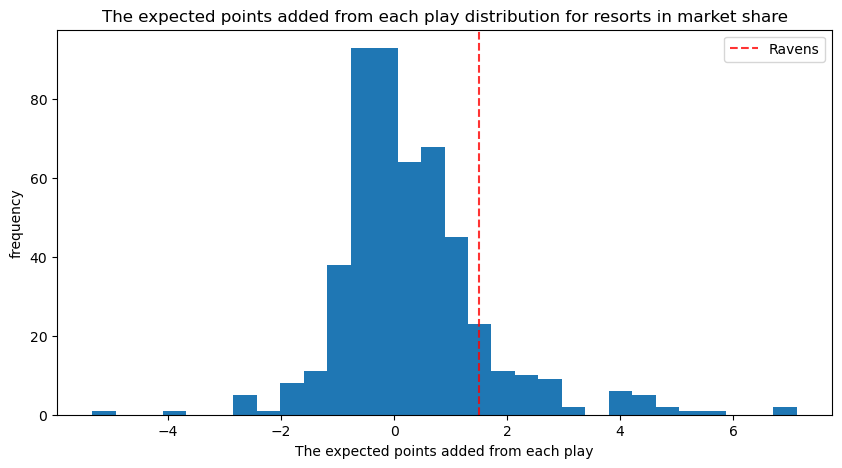

In [97]:
plot_compare('expectedPointsAdded', 'The expected points added from each play')

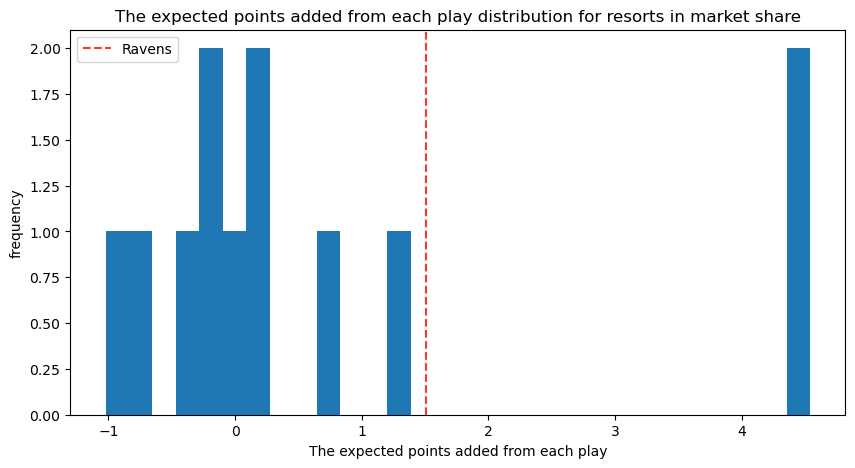

In [98]:
plot_compare('expectedPointsAdded', 'The expected points added from each play', club = 'MIA')

### Play Result

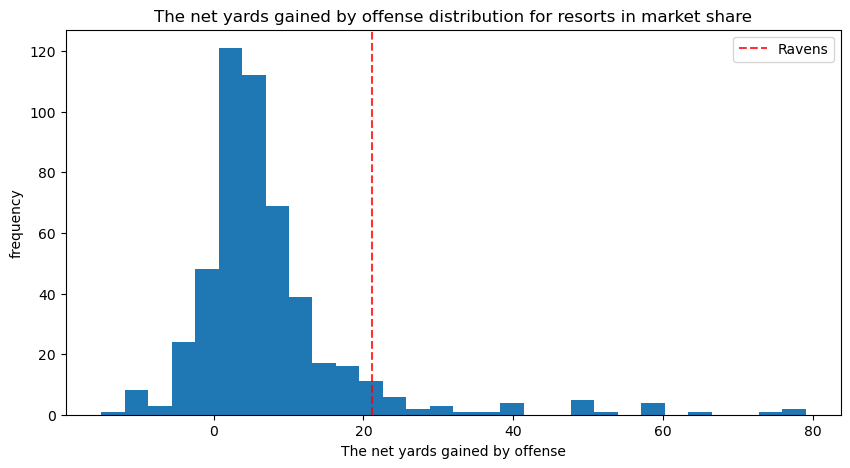

In [99]:
plot_compare('playResult', 'The net yards gained by offense')

### Pre Penalty Play Result

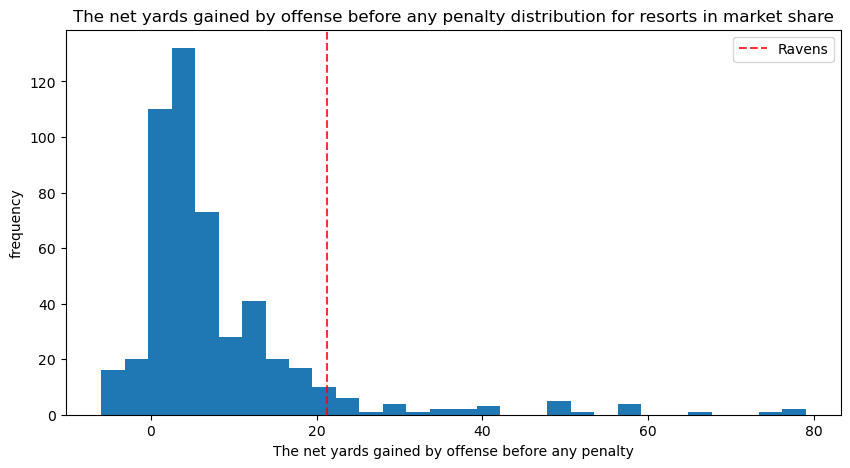

In [100]:
plot_compare('prePenaltyPlayResult', 'The net yards gained by offense before any penalty')

### Yards To Go

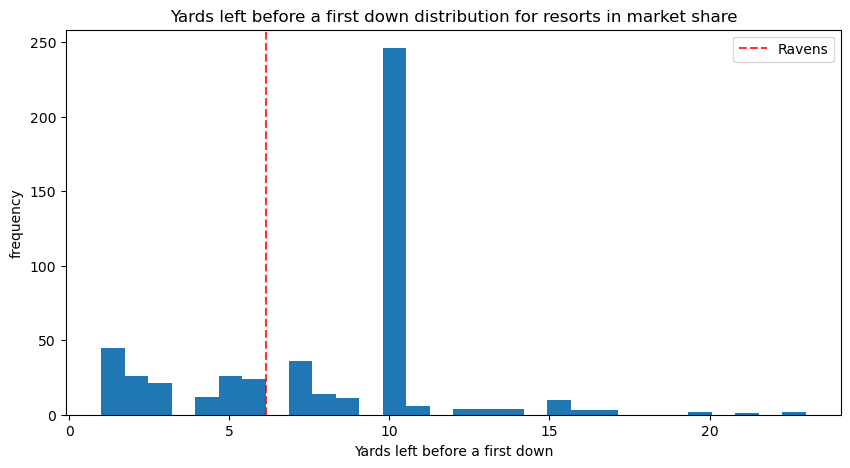

In [101]:
plot_compare('yardsToGo', 'Yards left before a first down')

### Down

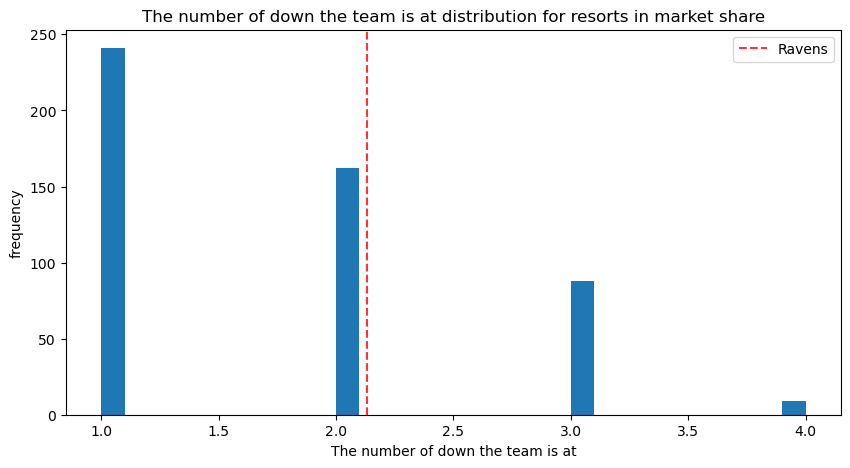

In [102]:
plot_compare('down', "The number of down the team is at")

# Model Scenarios

Lets say we want to bring the expected points added for each play up to a 2.

In [198]:
feats = ['playResult', 'prePenaltyPlayResult', 'yardsToGo', 'down']

In [199]:
rav[feats]

,playResult,prePenaltyPlayResult,yardsToGo,down
5986,79,79,2,3
6825,7,7,6,2
5794,4,4,10,1
6025,79,79,2,3
6354,16,16,10,1
6058,2,2,3,3
5415,6,6,10,1
6668,17,17,7,3
5746,0,0,1,3
6043,2,2,3,3


In [200]:
np.mean(rav[feats])

/Users/cyn/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


playResult              21.200000
prePenaltyPlayResult    21.200000
yardsToGo                6.133333
down                     2.133333
dtype: float64

In [201]:
np.mean(rav['playResult'])

21.2

In [202]:
len(rav)

15

## Scenarios

In [203]:
def predictions(features, deltas):
    """ Changing features by deltas to see how it will
        affect the expected points added
    """
    rav2 = X_rav.copy()
    for f, d in zip((features), deltas):
        rav2[features] += deltas
    return np.mean(RF_pipe.predict(X_rav)) / np.mean(RF_pipe.predict(rav2))  

#### Scenario 1:

In [204]:
playdelta = [i for i in range(10, -5, -1)]
epa_delta = [predictions(['playResult'], [delta]) for delta in playdelta]

/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warning

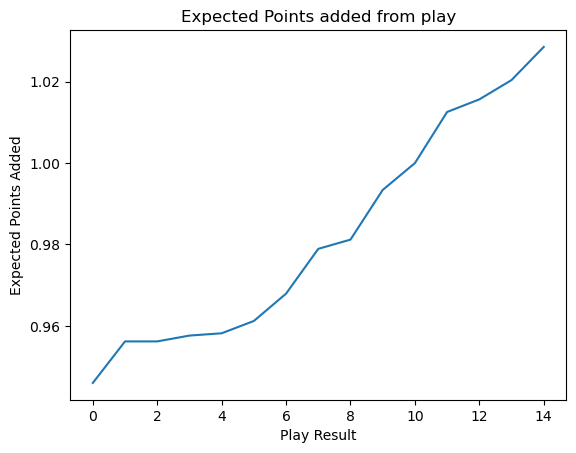

In [205]:
plt.plot(epa_delta)
plt.xlabel('Play Result')
plt.ylabel('Expected Points Added')
plt.title('Expected Points added from play')
plt.show()

#### Scenario 2:

Lets say that the play ran gave us a 4 yard gain, and only have 6 more yards to go at a second yard. What is our expected points added?

In [219]:
scenario2_shotgun = predictions(['offenseFormation_SHOTGUN', 'playResult', 'yardsToGo', 'down'], [1,4, 6, 2])

/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [220]:
scenario2_shotgun

0.935987341025051

In [223]:
scenario2_singleback = predictions(['offenseFormation_SINGLEBACK', 'playResult', 'yardsToGo', 'down'], [1,4, 6, 2])

/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [224]:
scenario2_singleback

0.933119824179799

In [229]:
scenario2_I_FORM = predictions(['offenseFormation_I_FORM', 'playResult', 'yardsToGo', 'down'], [1,4, 6, 2])

/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [230]:
scenario2_I_FORM

0.9312979070904901

In [231]:
scenario2_PISTOL = predictions(['offenseFormation_PISTOL', 'playResult', 'yardsToGo', 'down'], [1,4, 6, 2])
scenario2_PISTOL

/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


0.9312979070904901

In [233]:
scenario2_JUMBO = predictions(['offenseFormation_JUMBO', 'playResult', 'yardsToGo', 'down'], [1,4, 6, 2])
scenario2_JUMBO

/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


0.9312979070904901

#### Scenario 3:

Lets say that the play ran gave us a 14 yard gain (lost 2 yards due to a foul), and only have 10 more yards to go at a first yard. What is our expected points added?

In [238]:
scenario3_shotgun =predictions(['offenseFormation_SHOTGUN','playResult', 'yardsToGo', 'down', 'prePenaltyPlayResult'], [1, 14, 10, 1, 16])
scenario3_shotgun

/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


0.6737174397421543

In [242]:
scenario3_singleback = predictions(['offenseFormation_SINGLEBACK', 'playResult', 'yardsToGo', 'down', 'prePenaltyPlayResult'], [1, 14, 10, 1, 16])
scenario3_singleback

/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


0.6728171569981625

In [243]:
scenario3_I_FORM = predictions(['offenseFormation_I_FORM', 'playResult', 'yardsToGo', 'down', 'prePenaltyPlayResult'], [1, 14, 10, 1, 16])
scenario3_I_FORM

/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


0.6718694272707595

In [244]:
scenario3_PISTOL = predictions(['offenseFormation_PISTOL', 'playResult', 'yardsToGo', 'down', 'prePenaltyPlayResult'], [1, 14, 10, 1, 16])
scenario3_PISTOL

/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


0.6718694272707595

In [245]:
scenario3_JUMBO = predictions(['offenseFormation_JUMBO', 'playResult', 'yardsToGo', 'down', 'prePenaltyPlayResult'], [1, 14, 10, 1, 16])
scenario3_JUMBO

/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/cyn/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['penaltyYards']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


0.6718694272707595

## Conclusions

After running various scenarios, it seems like the offensive formation of 'Shotgun' suits the team the best. After each scenario, that was the formation that brought in the most expected points added.